In [1]:
#code to correct table output in JupyterNotebook
#source: https://stackoverflow.com/questions/48357459/make-cell-output-in-jupyter-notebook-scroll-horizontally

from IPython.display import display, HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [2]:
#testing spark
spark

In [3]:
#importing required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, isnull, when, count, udf, avg, min, max, stddev, to_timestamp

In [4]:
#spark setup
spark = SparkSession.builder.appName("EDA_and_Cleaning").getOrCreate()
dataset_path = "gs://my-mlproject-bucket-rj/landing/itineraries.csv"

df = spark.read.csv(dataset_path, header=True, inferSchema = True)

24/11/21 01:18:22 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [5]:
df.printSchema()

root
 |-- legId: string (nullable = true)
 |-- searchDate: date (nullable = true)
 |-- flightDate: date (nullable = true)
 |-- startingAirport: string (nullable = true)
 |-- destinationAirport: string (nullable = true)
 |-- fareBasisCode: string (nullable = true)
 |-- travelDuration: string (nullable = true)
 |-- elapsedDays: integer (nullable = true)
 |-- isBasicEconomy: boolean (nullable = true)
 |-- isRefundable: boolean (nullable = true)
 |-- isNonStop: boolean (nullable = true)
 |-- baseFare: double (nullable = true)
 |-- totalFare: double (nullable = true)
 |-- seatsRemaining: integer (nullable = true)
 |-- totalTravelDistance: integer (nullable = true)
 |-- segmentsDepartureTimeEpochSeconds: string (nullable = true)
 |-- segmentsDepartureTimeRaw: string (nullable = true)
 |-- segmentsArrivalTimeEpochSeconds: string (nullable = true)
 |-- segmentsArrivalTimeRaw: string (nullable = true)
 |-- segmentsArrivalAirportCode: string (nullable = true)
 |-- segmentsDepartureAirportCode: s

In [6]:
df.show(5)

24/11/21 01:19:28 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+----------+----------+---------------+------------------+-------------+--------------+-----------+--------------+------------+---------+--------+---------+--------------+-------------------+---------------------------------+------------------------+-------------------------------+----------------------+--------------------------+----------------------------+-------------------+-------------------+----------------------------+-------------------------+----------------+-----------------+
|               legId|searchDate|flightDate|startingAirport|destinationAirport|fareBasisCode|travelDuration|elapsedDays|isBasicEconomy|isRefundable|isNonStop|baseFare|totalFare|seatsRemaining|totalTravelDistance|segmentsDepartureTimeEpochSeconds|segmentsDepartureTimeRaw|segmentsArrivalTimeEpochSeconds|segmentsArrivalTimeRaw|segmentsArrivalAirportCode|segmentsDepartureAirportCode|segmentsAirlineName|segmentsAirlineCode|segmentsEquipmentDescription|segmentsDurationInSeconds|segmentsDi

In [7]:
#number of rows and columns
print(f"Number of rows: {df.count()}")
print(f"Number of columns: {len(df.columns)}")

Number of rows: 82138753
Number of columns: 27


In [8]:
#listing all columns
print("Columns:", df.columns)

Columns: ['legId', 'searchDate', 'flightDate', 'startingAirport', 'destinationAirport', 'fareBasisCode', 'travelDuration', 'elapsedDays', 'isBasicEconomy', 'isRefundable', 'isNonStop', 'baseFare', 'totalFare', 'seatsRemaining', 'totalTravelDistance', 'segmentsDepartureTimeEpochSeconds', 'segmentsDepartureTimeRaw', 'segmentsArrivalTimeEpochSeconds', 'segmentsArrivalTimeRaw', 'segmentsArrivalAirportCode', 'segmentsDepartureAirportCode', 'segmentsAirlineName', 'segmentsAirlineCode', 'segmentsEquipmentDescription', 'segmentsDurationInSeconds', 'segmentsDistance', 'segmentsCabinCode']


In [9]:
#counting the amount of non-null records in each column
non_null_values = (
    df.select([count(when(~isnull(c), c)).alias(c) for c in df.columns])
    .first()
    .asDict()
)
for k, v in non_null_values.items():
    print(f"{k}: {v}")

legId: 82138753
searchDate: 82138753
flightDate: 82138753
startingAirport: 82138753
destinationAirport: 82138753
fareBasisCode: 82138753
travelDuration: 82138753
elapsedDays: 82138753
isBasicEconomy: 82138753
isRefundable: 82138753
isNonStop: 82138753
baseFare: 82138753
totalFare: 82138753
seatsRemaining: 82138753
totalTravelDistance: 76044221
segmentsDepartureTimeEpochSeconds: 82138753
segmentsDepartureTimeRaw: 82138753
segmentsArrivalTimeEpochSeconds: 82138753
segmentsArrivalTimeRaw: 82138753
segmentsArrivalAirportCode: 82138753
segmentsDepartureAirportCode: 82138753
segmentsAirlineName: 82138753
segmentsAirlineCode: 82138753
segmentsEquipmentDescription: 80581161
segmentsDurationInSeconds: 82138753
segmentsDistance: 82138753
segmentsCabinCode: 82138753


In [10]:
#counting the number of missing values in each column
missing_values = (
    df.select([count(when(isnull(c), c)).alias(c) for c in df.columns])
    .first()
    .asDict()
)

for k, v in missing_values.items():
    print(f"{k}: {v}")

legId: 0
searchDate: 0
flightDate: 0
startingAirport: 0
destinationAirport: 0
fareBasisCode: 0
travelDuration: 0
elapsedDays: 0
isBasicEconomy: 0
isRefundable: 0
isNonStop: 0
baseFare: 0
totalFare: 0
seatsRemaining: 0
totalTravelDistance: 6094532
segmentsDepartureTimeEpochSeconds: 0
segmentsDepartureTimeRaw: 0
segmentsArrivalTimeEpochSeconds: 0
segmentsArrivalTimeRaw: 0
segmentsArrivalAirportCode: 0
segmentsDepartureAirportCode: 0
segmentsAirlineName: 0
segmentsAirlineCode: 0
segmentsEquipmentDescription: 1557592
segmentsDurationInSeconds: 0
segmentsDistance: 0
segmentsCabinCode: 0


In [11]:
#calculating the min/max/avg/stdev for all numeric variables
numeric_variables = [
    'elapsedDays', 
    'baseFare', 
    'totalFare', 
    'seatsRemaining', 
    'totalTravelDistance'
]

stats = df.select(
    [avg(col).alias(f"avg_{col}") for col in numeric_variables] +
    [min(col).alias(f"min_{col}") for col in numeric_variables] +
    [max(col).alias(f"max_{col}") for col in numeric_variables] +
    [stddev(col).alias(f"stdev_{col}") for col in numeric_variables]
)

stats_dict = stats.collect()[0].asDict()

for k, v in stats_dict.items():
    print(f"{k}: {v}")

avg_elapsedDays: 0.14965308762357277
avg_baseFare: 292.6628527106179
avg_totalFare: 340.38684913979085
avg_seatsRemaining: 5.976311522528228
avg_totalTravelDistance: 1609.9033457519408
min_elapsedDays: 0
min_baseFare: 0.01
min_totalFare: 19.59
min_seatsRemaining: 0
min_totalTravelDistance: 89
max_elapsedDays: 2
max_baseFare: 7662.33
max_totalFare: 8260.61
max_seatsRemaining: 10
max_totalTravelDistance: 7252
stdev_elapsedDays: 0.3567567481729477
stdev_baseFare: 183.18878337398354
stdev_totalFare: 196.02950991170567
stdev_seatsRemaining: 2.8805671114637628
stdev_totalTravelDistance: 857.3257345475689


In [12]:
#calculating the minimum and maximum dates for date variables
date_stats = df.select(
    min("searchDate").alias("min_searchDate"),
    max("searchDate").alias("max_searchDate"),
    min("flightDate").alias("min_flightDate"),
    max("flightDate").alias("max_flightDate")
)

date_stats_dict = date_stats.collect()[0].asDict()

for k, v in date_stats_dict.items():
    print(f"{k}: {v}")

min_searchDate: 2022-04-16
max_searchDate: 2022-10-05
min_flightDate: 2022-04-17
max_flightDate: 2022-11-19


In [13]:
#conversion to pandas for data visualization
sair_df = df.select('startingAirport').sample(False, 0.10).toPandas()
sair_df.head()


,startingAirport
0,ATL
1,ATL
2,ATL
3,ATL
4,ATL


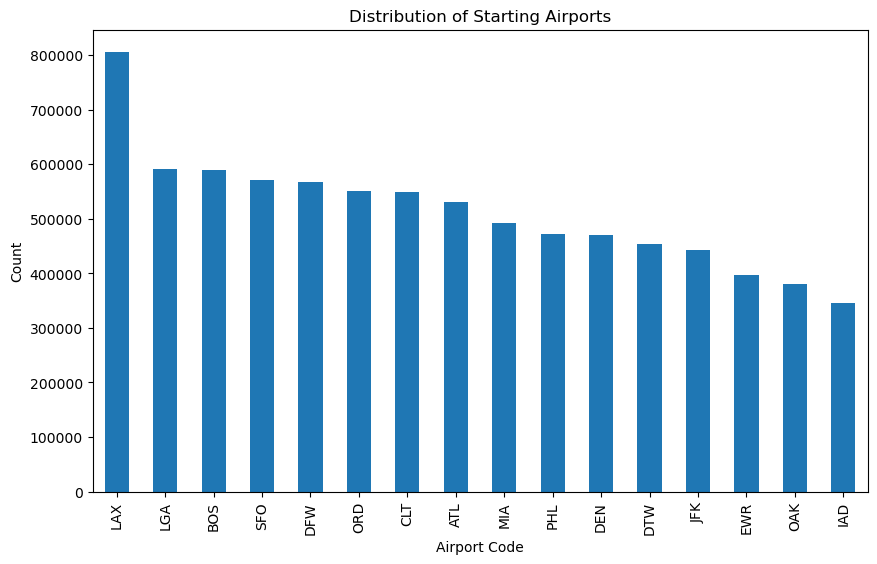

In [14]:
#barchart for starting aiport code
starting_airport = sair_df['startingAirport'].value_counts()
starting_airport.plot(kind='bar', figsize=(10, 6))
plt.title('Distribution of Starting Airports')
plt.xlabel('Airport Code')
plt.ylabel('Count')
plt.show()


In [15]:
dair_df = df.select('destinationAirport').sample(False, 0.10).toPandas()
dair_df.head()

,destinationAirport
0,BOS
1,BOS
2,BOS
3,BOS
4,CLT


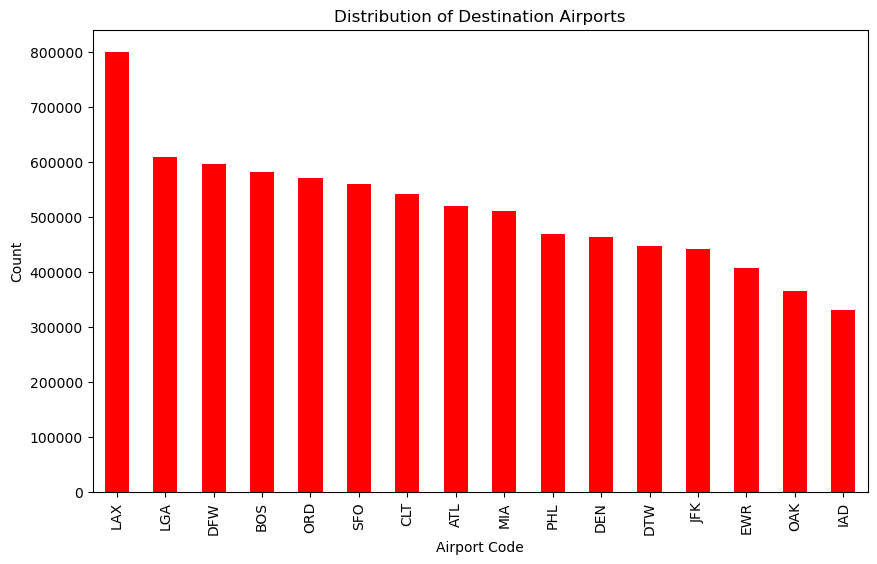

In [16]:
#distribution of destination airports
destination_airport = dair_df['destinationAirport'].value_counts()
destination_airport.plot(kind='bar', figsize=(10, 6), color='red')
plt.title('Distribution of Destination Airports')
plt.xlabel('Airport Code')
plt.ylabel('Count')
plt.show()

In [17]:
tfare_df = df.select('totalFare').sample(False, 0.10).toPandas()
tfare_df.head()

,totalFare
0,302.11
1,318.60
2,398.60
3,387.60
4,398.60


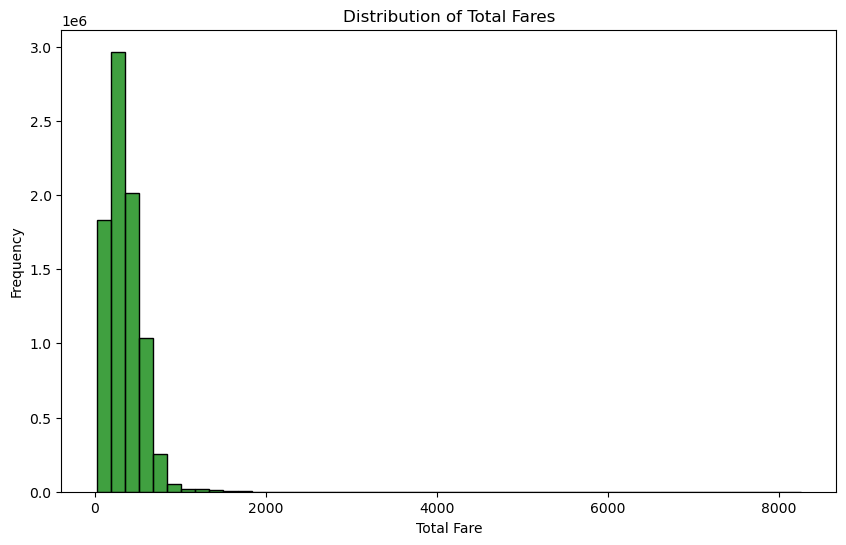

In [18]:
# distribution of total fares
plt.figure(figsize=(10, 6))
sns.histplot(data=tfare_df, x='totalFare', bins=50, color='green')
plt.title('Distribution of Total Fares')
plt.xlabel('Total Fare')
plt.ylabel('Frequency')
plt.show()

In [25]:
tdistance_df = df.select('totalTravelDistance').sample(False, 0.10).toPandas()
tdistance_df.head()

,totalTravelDistance
0,947.0
1,956.0
2,947.0
3,947.0
4,1207.0


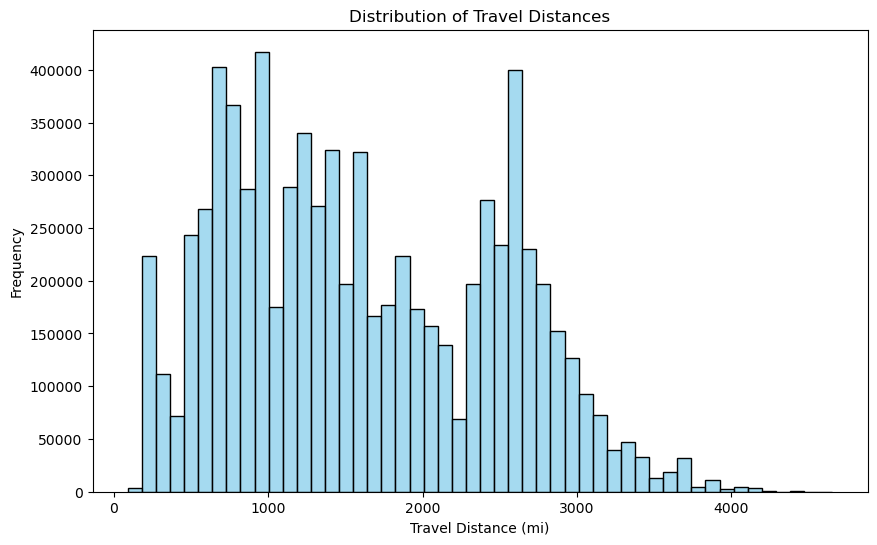

In [27]:
plt.figure(figsize=(10, 6))
sns.histplot(data=tdistance_df, x='totalTravelDistance', bins=50, color='skyblue')
plt.title('Distribution of Travel Distances')
plt.xlabel('Travel Distance (mi)')
plt.ylabel('Frequency')
plt.show()

In [19]:
basefare_df = df.select('flightDate', 'baseFare').sample(False, 0.10).toPandas()
basefare_df.head()

,flightDate,baseFare
0,2022-04-17,217.67
1,2022-04-17,260.47
2,2022-04-17,357.21
3,2022-04-17,357.21
4,2022-04-17,349.76


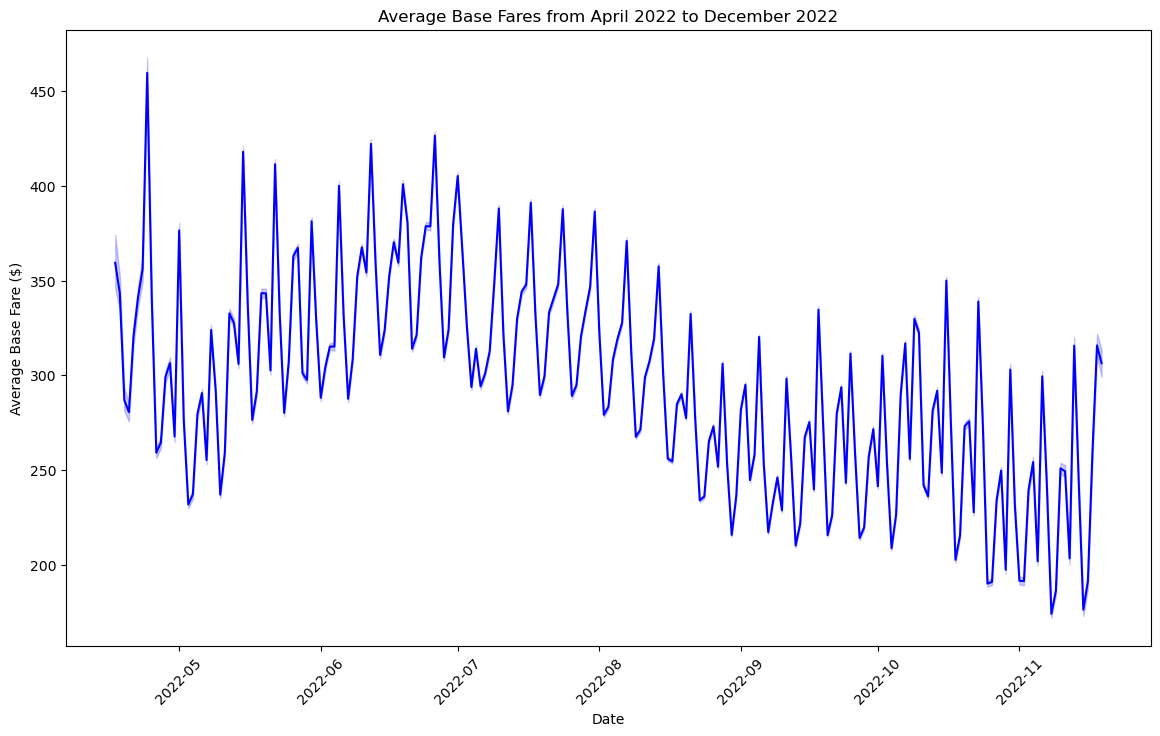

In [20]:
#average base fares over time
plt.figure(figsize=(14, 8))
sns.lineplot(data=basefare_df, x='flightDate', y='baseFare', color='blue')

plt.title('Average Base Fares from April 2022 to December 2022')
plt.xlabel('Date')
plt.ylabel('Average Base Fare ($)')

plt.xticks(rotation=45)
plt.show()

In [21]:
farecomp_df = df.select('baseFare', 'totalFare').sample(False, 0.10).toPandas()
farecomp_df.head()



,baseFare,totalFare
0,217.67,248.60
1,183.00,290.58
2,265.58,300.10
3,357.21,398.60
4,356.28,406.60


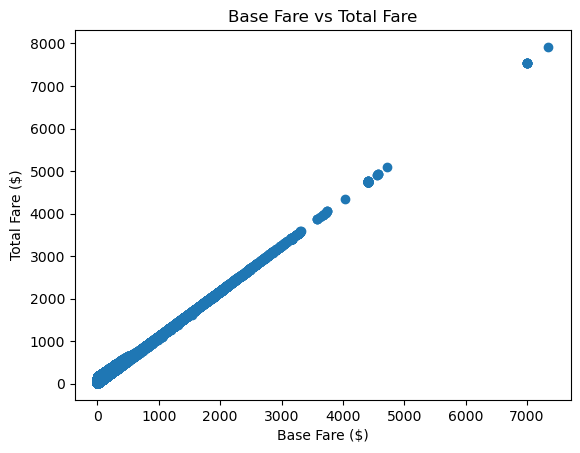

In [22]:
#comparing base fares and total fares
plt.scatter(farecomp_df["baseFare"], farecomp_df["totalFare"])
plt.title("Base Fare vs Total Fare")
plt.xlabel("Base Fare ($)")
plt.ylabel("Total Fare ($)")
plt.show()

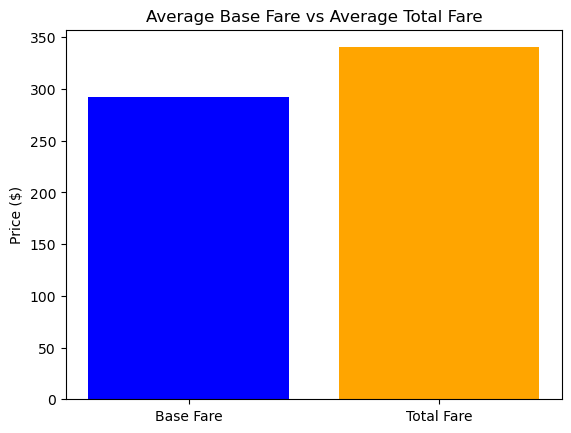

In [23]:
#comparing average base fare vs average total fare (bar chart)
average_baseFare = farecomp_df["baseFare"].mean()
average_totalFare = farecomp_df["totalFare"].mean()

data = {"Fare Type": ["Base Fare", "Total Fare"], 
        "Average": [average_baseFare, average_totalFare]}

plt.bar(data["Fare Type"], data["Average"], color=["blue", "orange"])
plt.title("Average Base Fare vs Average Total Fare")
plt.ylabel("Price ($)")
plt.show()